# Week 5 Homework

---

## Q1: [PyMC Example Gallery](https://github.com/Chuxuan-a/Bayes/blob/main/Gallery.ipynb)





## Q2: PyMC Bayesian Inference & Model Diagnostics

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*



In [2]:
import pymc
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import arviz as az

In [7]:
n = 100
true_theta, true_tau = 10, 0.5
norm = stats.norm(loc=true_theta, scale=true_tau**(-0.5))

np.random.seed(30)
x = norm.rvs(size=n)

In [39]:
normal_gamma = pymc.Model()

with normal_gamma:
    
    # Prior parameters
    theta0 = 5
    sigma0 = 5
    tau_SS_prior = 1  # Prior sum of squares belief for tau
    tau_prior_n = 1  # Strength of prior belief (in data units)
    
    
    # Priors
    theta = pymc.Normal("theta", mu=theta0, sigma=sigma0)  # Prior for mean
    tau = pymc.Gamma("tau", alpha=tau_prior_n / 2, beta=tau_SS_prior / 2)  # Prior for precision

    # Likelihood of observed data
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)
    


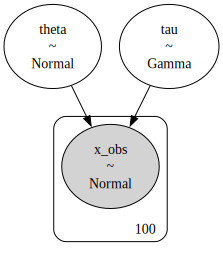

In [40]:
pymc.model_to_graphviz(normal_gamma)

In [41]:
m = 10000
with normal_gamma:
    idata = pymc.sample(draws=m, chains=4, tune=200)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 4 chains for 200 tune and 10_000 draw iterations (800 + 40_000 draws total) took 8 seconds.


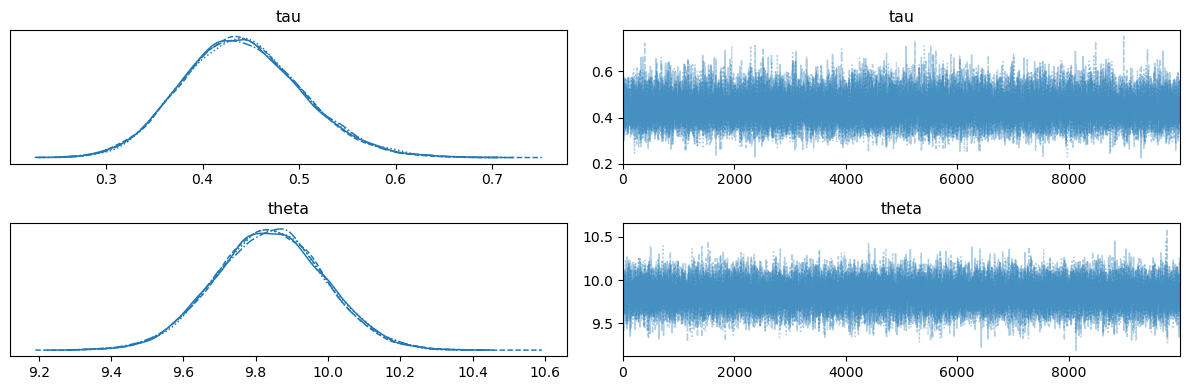

In [42]:
az.plot_trace(idata)
plt.tight_layout()

Both posterior densities are smooth and unimodal, centered slighly below the true value, which are reasonable given our relatively low true precision, the small sample size and prior on precision being slighly off. 

The trace plots show stable and random fluctuation, without strong trends, indicating the MCMC algorithm is mixing well and converging.

In [43]:
az.summary(idata, round_to=4, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.4416,0.0623,0.3242,0.5668,0.0004,0.0003,31124.2812,25133.0843,1.0001
theta,9.8385,0.1516,9.5478,10.1400,0.0009,0.0006,31726.2118,25800.3307,1.0002


- $\hat{R}$ for both $\tau$ and $\theta$ is very close to 1, which confirms that the MCMC chains have properly converged to the true posterior. 
- Both mean values are quite close to their true value, and are within their 95% HDI. 
- The MCSE values are very small, showing that the estimation accuracy is quite high. 
- ~~Note that the bulk ESS is larger than the actual sample size, meaning the ESS is slightly inflated by the presence of negative autocorrelation.~~
- The bulk ESS is large enough to ensure that there is enough effective samples.


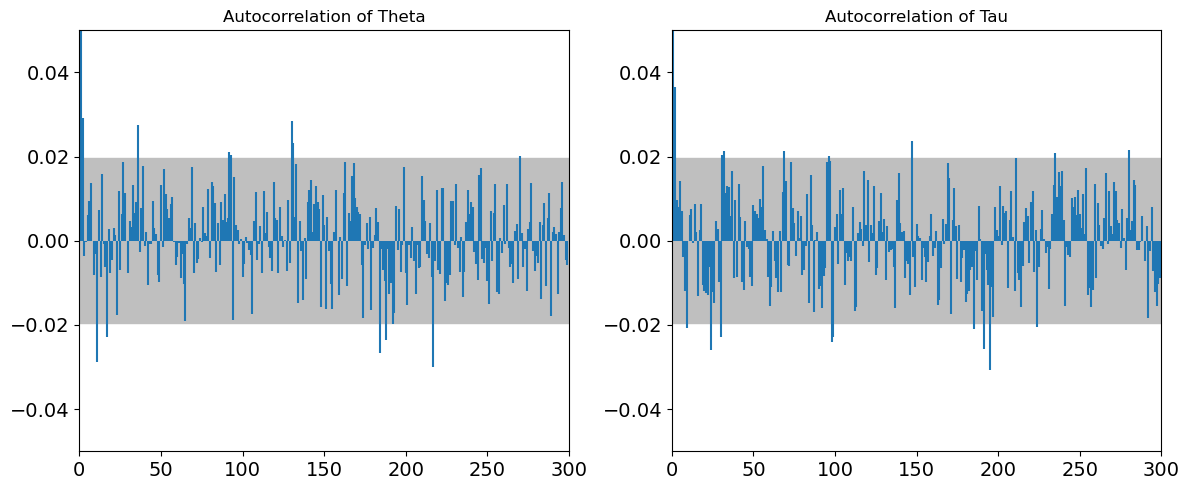

In [44]:
# Autocorrelation plot using arviz

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot autocorrelation for theta
az.plot_autocorr(idata, var_names=["theta"], max_lag=300, ax=axes[0])
axes[0].set_title("Autocorrelation of Theta")
axes[0].set_ylim(-0.05, 0.05) 

# Plot autocorrelation for tau
az.plot_autocorr(idata, var_names=["tau"], max_lag=300, ax=axes[1])
axes[1].set_title("Autocorrelation of Tau")
axes[1].set_ylim(-0.05, 0.05)  

plt.tight_layout()
plt.show()

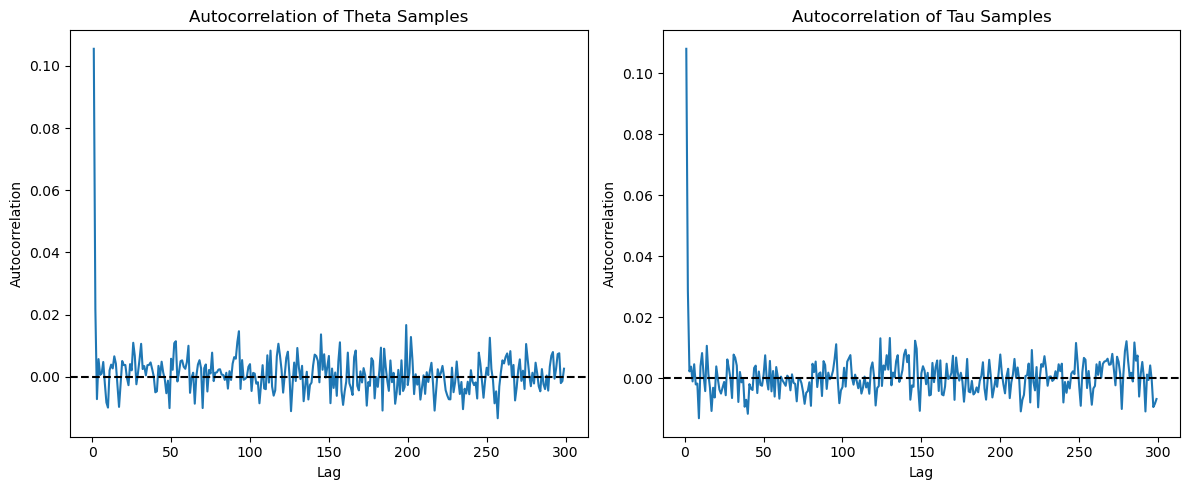

In [47]:
# Manual Autocorrelation line plot

# Extract theta and tau samples from all chains and flatten into 1D arrays
theta_samples = idata.posterior["theta"].values.flatten()
tau_samples = idata.posterior["tau"].values.flatten()

def autocorr(x, lag):
    """Compute autocorrelation for a given lag."""
    return np.corrcoef(x[:-lag], x[lag:])[0, 1] if lag > 0 else 1

# Set maximum number of lags
max_lag = 300
lags = np.arange(1, max_lag)

# Compute autocorrelations for each lag
theta_autocorr = [autocorr(theta_samples, lag) for lag in lags]
tau_autocorr = [autocorr(tau_samples, lag) for lag in lags]

plt.figure(figsize=(12, 5))

# Plot theta autocorrelation
plt.subplot(1, 2, 1)
plt.plot(lags, theta_autocorr, marker='', linestyle='-')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Theta Samples")
plt.axhline(0, color='black', linestyle='--')

# Plot tau autocorrelation
plt.subplot(1, 2, 2)
plt.plot(lags, tau_autocorr, marker='', linestyle='-')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Tau Samples")
plt.axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

The autocorrelation gets to 0 almost immediately and then fluctuates randomly around 0, suggesting that chains are mixing extremely well, and that the samples are nearly independent. This explains why we got ESS > n, and confirms efficiency in sampling.


2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

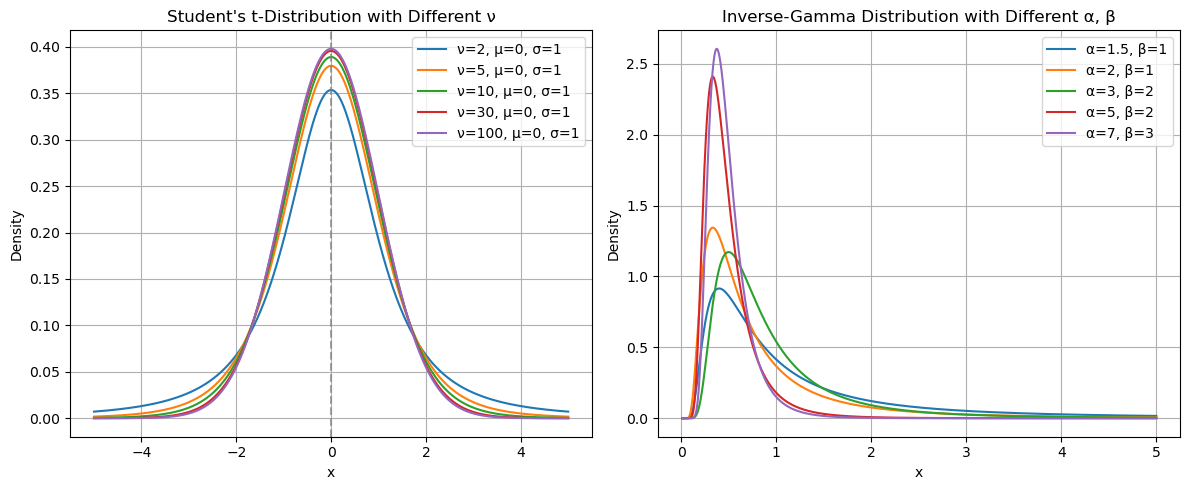

In [10]:
x_t = np.linspace(-5, 5, 1000)  # Student's t
x_ig = np.linspace(0.01, 5, 1000)  # Inverse-Gamma

t_params = [(2, 0, 1), (5, 0, 1), (10, 0, 1), (30, 0, 1), (100, 0, 1)] 
ig_params = [(1.5, 1), (2, 1), (3, 2), (5, 2), (7, 3)]


plt.figure(figsize=(12, 5))

# Student's t-distribution
plt.subplot(1, 2, 1)
for nu, mu, sigma in t_params:
    pdf_t = stats.t.pdf(x_t, df=nu, loc=mu, scale=sigma)
    plt.plot(x_t, pdf_t, label=f"ν={nu}, μ={mu}, σ={sigma}")

plt.axvline(0, linestyle="--", color="gray", alpha=0.7)
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Student's t-Distribution with Different ν")
plt.legend()
plt.grid()

# Inverse-Gamma distribution
plt.subplot(1, 2, 2)
for alpha, beta in ig_params:
    pdf_ig = stats.invgamma.pdf(x_ig, a=alpha, scale=beta)
    plt.plot(x_ig, pdf_ig, label=f"α={alpha}, β={beta}")

plt.xlabel("x")
plt.ylabel("Density")
plt.title("Inverse-Gamma Distribution with Different α, β")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [13]:
# Student's t - Inverse Gamma

with pymc.Model() as t_inv_gamma:
    
    theta = pymc.StudentT("theta", nu=5, mu=theta0, sigma=sigma0)
    tau = pymc.InverseGamma("tau", alpha=2, beta=2) 
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)

    idata_t_inv_gamma = pymc.sample(draws=10000, chains=4, tune=200, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 4 chains for 200 tune and 10_000 draw iterations (800 + 40_000 draws total) took 9 seconds.


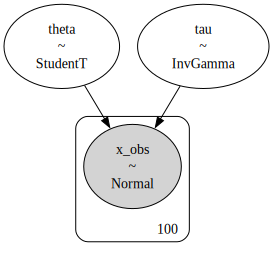

In [14]:
pymc.model_to_graphviz(t_inv_gamma)

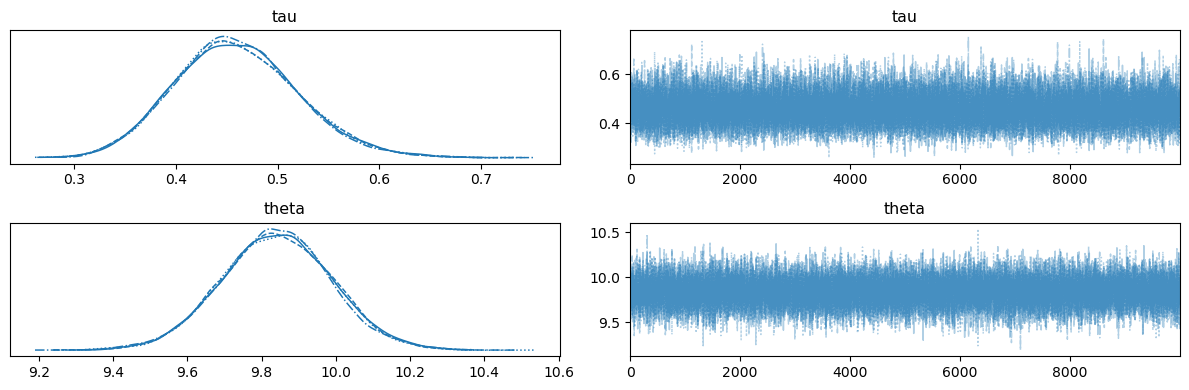

In [13]:
az.plot_trace(idata_t_inv_gamma)
plt.tight_layout()

In [14]:
summary_t_inv_gamma = az.summary(idata_t_inv_gamma, round_to=5, hdi_prob=0.95)
summary_t_inv_gamma

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.45943,0.06046,0.34028,0.57600,0.00033,0.00024,32719.62280,25675.80769,1.00025
theta,9.83919,0.14886,9.54288,10.12717,0.00084,0.00059,31450.53942,24713.21239,1.00021


Again, the posterior distributions for $\theta$ and $\tau$ appear smooth and unimodal, with estimates centered near the expected values. The density for $\tau$ slightly underestimates the true precision, which aligns with prior uncertainty.

The trace plots show well-mixed chains with no clear trends, indicating good convergence and efficient sampling.

The $\hat{R}$ values for both parameters are very close to 1, confirming that the MCMC chains have converged properly. The mean estimates both lie within the 95% HDI. The MCSE are small, reinforcing the reliability of the parameter estimates. Also, the effective sample size is quite large, the chains are well-mixed.

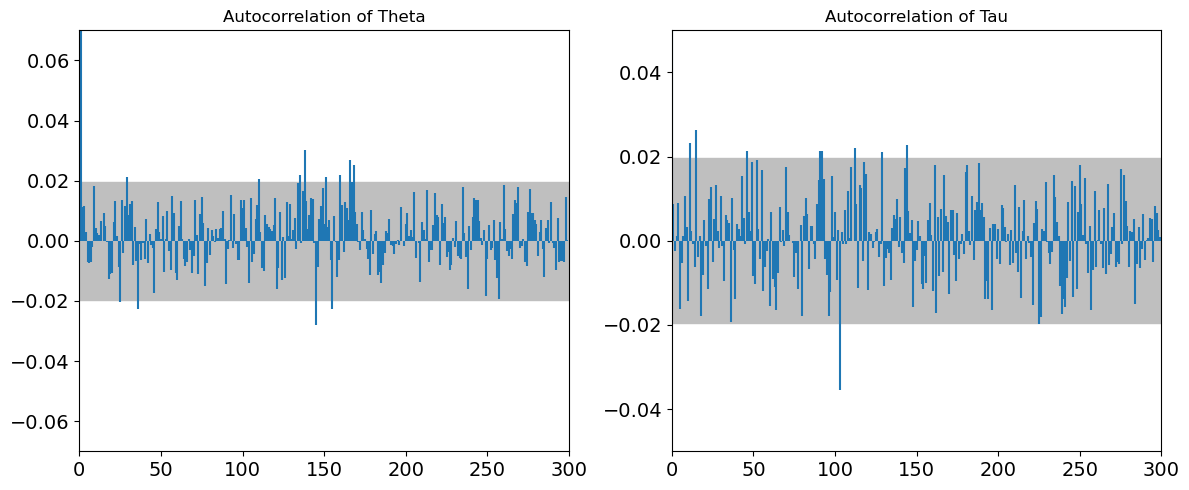

In [15]:
# Autocorrelation plot using arviz

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # One row, two columns

# Plot autocorrelation for theta
az.plot_autocorr(idata_t_inv_gamma, var_names=["theta"], max_lag=300, ax=axes[0])
axes[0].set_title("Autocorrelation of Theta")
axes[0].set_ylim(-0.07, 0.07) 

# Plot autocorrelation for tau
az.plot_autocorr(idata_t_inv_gamma, var_names=["tau"], max_lag=300, ax=axes[1])
axes[1].set_title("Autocorrelation of Tau")
axes[1].set_ylim(-0.05, 0.05)  

plt.tight_layout()
plt.show()

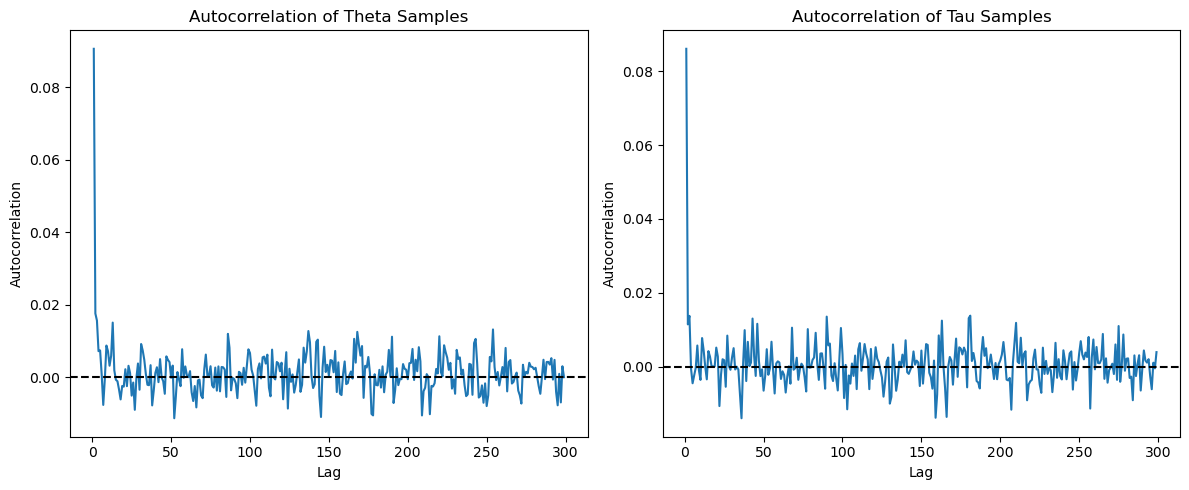

In [16]:
# Manual Autocorrelation Line Plot
theta_samples = idata_t_inv_gamma.posterior["theta"].values.flatten()
tau_samples = idata_t_inv_gamma.posterior["tau"].values.flatten()


max_lag = 300
lags = np.arange(1, max_lag)
theta_autocorr = [autocorr(theta_samples, lag) for lag in lags]
tau_autocorr = [autocorr(tau_samples, lag) for lag in lags]

plt.figure(figsize=(12, 5))

# Plot theta autocorrelation
plt.subplot(1, 2, 1)
plt.plot(lags, theta_autocorr, marker='', linestyle='-')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Theta Samples")
plt.axhline(0, color='black', linestyle='--')

# Plot tau autocorrelation
plt.subplot(1, 2, 2)
plt.plot(lags, tau_autocorr, marker='', linestyle='-')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Tau Samples")
plt.axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()



For the two different plotting mechanisms, there is a noticeable contrast in their initial values. The ArviZ method applies normalization and accounts for multiple chains, giving a smoother estimate of how quickly the dependence decays. In contrast, the manual method computes raw Pearson correlations, which naturally start at a higher value before dropping off (autocorrelation at lag = 0 is always 1 by definition $\text{corr}(X_t, X_t) = 1$). This difference does not affect the conclusion, as both methods confirm that the chains mix well and the samples are nearly independent.

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

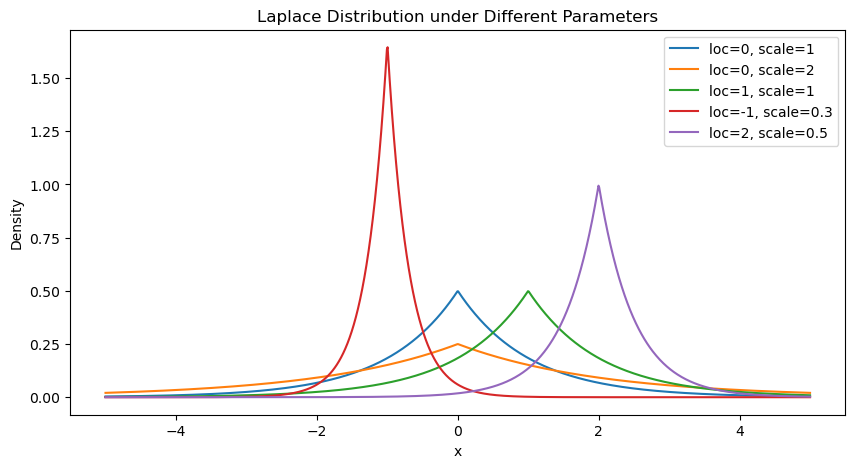

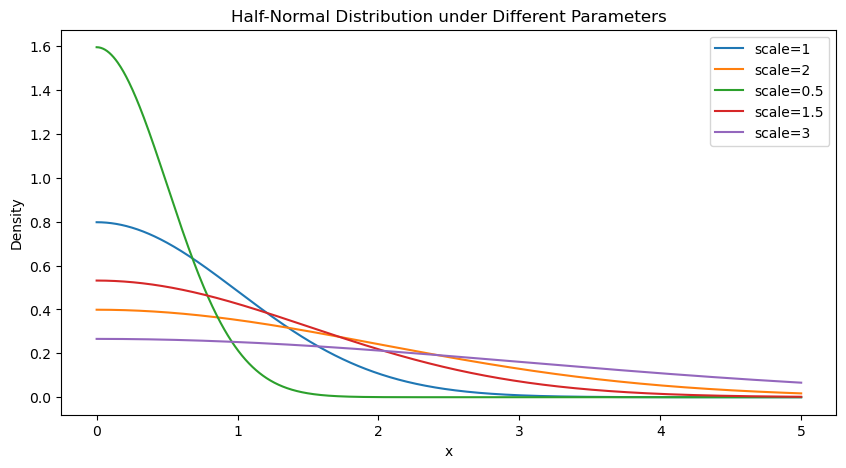

In [4]:
laplace_params = [(0, 1), (0, 2), (1, 1), (-1, 0.3), (2, 0.5)]
halfnorm_params = [(1), (2), (0.5), (1.5), (3)]

x_laplace = np.linspace(-5, 5, 1000)
x_halfnorm = np.linspace(0, 5, 1000)

# Laplace distribution plots
plt.figure(figsize=(10, 5))
for loc, scale in laplace_params:
    plt.plot(x_laplace, stats.laplace.pdf(x_laplace, loc, scale), label=f'loc={loc}, scale={scale}')
plt.title("Laplace Distribution under Different Parameters")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

# Half-Normal distribution plots
plt.figure(figsize=(10, 5))
for scale in halfnorm_params:
    plt.plot(x_halfnorm, stats.halfnorm.pdf(x_halfnorm, scale=scale), label=f'scale={scale}')
plt.title("Half-Normal Distribution under Different Parameters")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

In [10]:
# Laplace - Half-Normal

with pymc.Model() as laplace_halfnormal:

    theta = pymc.Laplace("theta", mu=5, b=3)  # scale = 3 

    tau = pymc.HalfNormal("tau", sigma=1) 

    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)

    idata_laplace_halfnormal = pymc.sample(draws=10000, chains=4, tune=200, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 4 chains for 200 tune and 10_000 draw iterations (800 + 40_000 draws total) took 8 seconds.


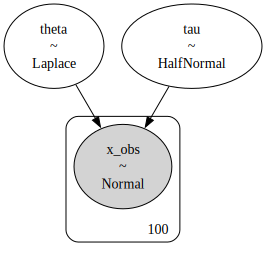

In [11]:
pymc.model_to_graphviz(laplace_halfnormal)

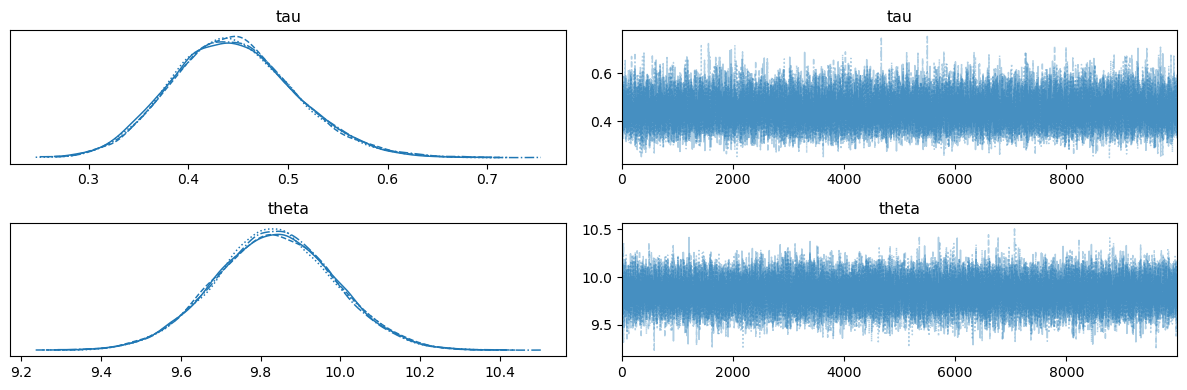

In [51]:
az.plot_trace(idata_laplace_halfnormal)
plt.tight_layout()

In [52]:
summary_laplace_halfnormal = az.summary(idata_laplace_halfnormal, round_to=5, hdi_prob=0.95)
summary_laplace_halfnormal

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.44532,0.06255,0.32769,0.57169,0.00035,0.00025,31597.71503,26455.58462,1.00018
theta,9.83578,0.15009,9.54647,10.13515,0.00086,0.00061,30405.89655,24931.83577,1.00032


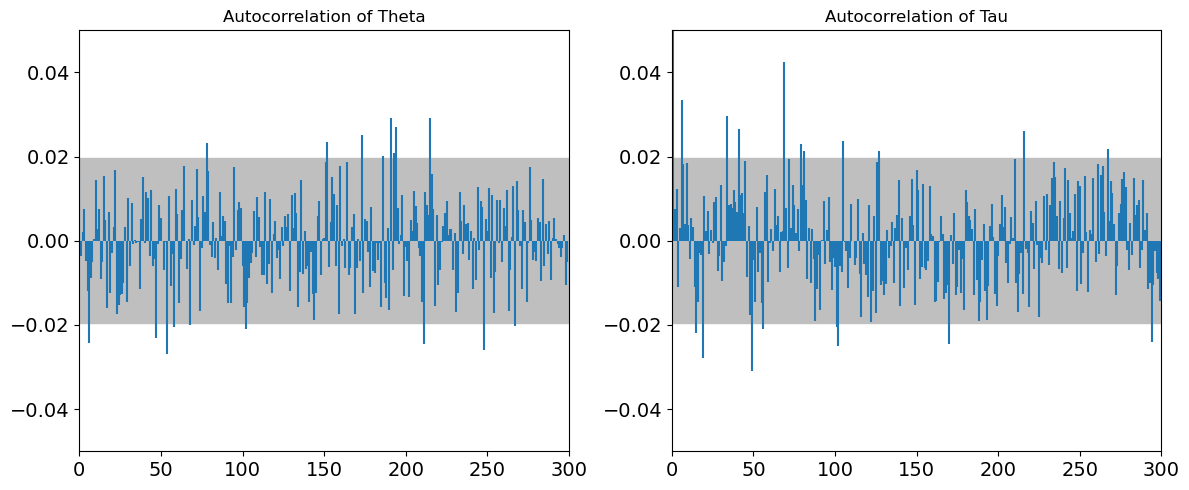

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# autocorrelation for theta
az.plot_autocorr(idata_laplace_halfnormal, var_names=["theta"], max_lag=300, ax=axes[0])
axes[0].set_title("Autocorrelation of Theta")
axes[0].set_ylim(-0.05, 0.05)

# autocorrelation for tau
az.plot_autocorr(idata_laplace_halfnormal, var_names=["tau"], max_lag=300, ax=axes[1])
axes[1].set_title("Autocorrelation of Tau")
axes[1].set_ylim(-0.05, 0.05)

plt.tight_layout()
plt.show()

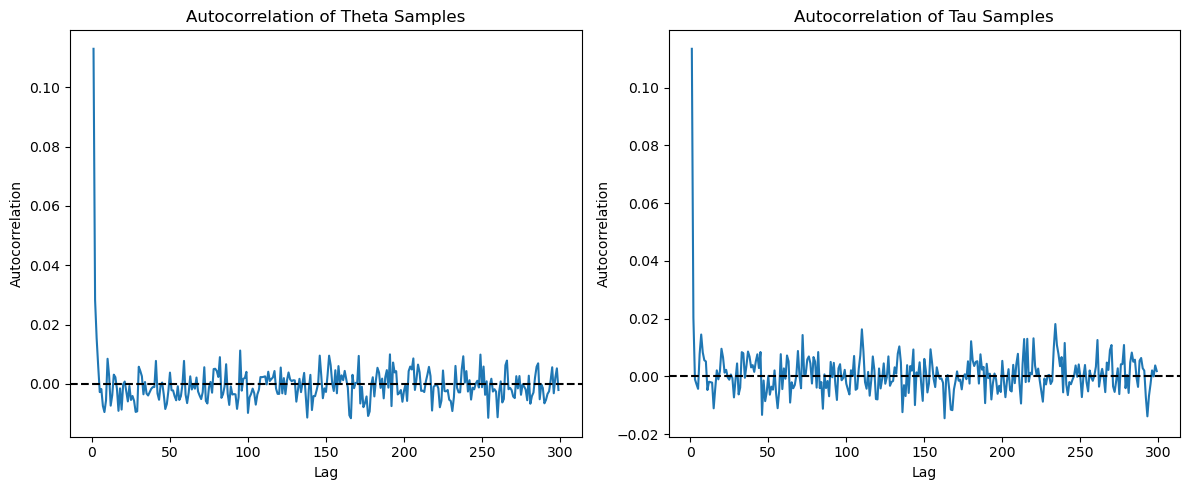

In [54]:
# Manual Autocorrelation Line Plot
theta_samples = idata_laplace_halfnormal.posterior["theta"].values.flatten()
tau_samples = idata_laplace_halfnormal.posterior["tau"].values.flatten()

max_lag = 300
lags = np.arange(1, max_lag)
theta_autocorr = [autocorr(theta_samples, lag) for lag in lags]
tau_autocorr = [autocorr(tau_samples, lag) for lag in lags]

plt.figure(figsize=(12, 5))

# theta autocorrelation
plt.subplot(1, 2, 1)
plt.plot(lags, theta_autocorr, marker='', linestyle='-')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Theta Samples")
plt.axhline(0, color='black', linestyle='--')

# tau autocorrelation
plt.subplot(1, 2, 2)
plt.plot(lags, tau_autocorr, marker='', linestyle='-')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Tau Samples")
plt.axhline(0, color='black', linestyle='--')

plt.tight_layout()
plt.show()

Once again, all the metrics look good. The Laplace prior, which induces sharper peaks, does not appear to cause significant deviations in the posterior shape.  

The trace plots show well-mixed chains with no noticeable trends, indicating good convergence and efficient sampling. The chains fluctuate randomly around their respective means without drift, suggesting that the sampler has properly explored the posterior space.  

The $\hat{R}$ values for both parameters are approximately 1. The mean estimates for both are close to their true values, both falling well within the 95% HDI. The MCSE are small, reinforcing the stability of the estimates.

The Laplace prior on $\theta$ results in slightly higher initial autocorrelation compared to a Normal prior, which is expected due to the sharper peak and heavier tails of the distribution. However, the correlation quickly drops to near zero, ensuring efficient sampling. This behavior aligns with the large ESS observed in the summary table, indicating that the chains mix well and the sampler is effectively drawing independent samples.


&nbsp;
## Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

In [3]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):
    
    # find interval of grid points where f(x_grid) > y 
    # then extend the enterval so endpoints f(a)<y and f(b)<y 
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid
    
    x_ = a + stats.uniform().rvs()*(b-a)    
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f" 
    elif x_ < x:  # or if "x_ was above f on the left side of the interval" 
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):
    
    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)
    
    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


In [ ]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))
    
m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):
    
    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')
    
    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')
    
plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();


###  Explanation of the Slice Sampling Algorithm

This recursive algorithm works as follows:

1. Start with a current value $ x $.
2. Draw an auxiliary variable $ y $ uniformly from $ [0, f(x)] $, defining a horizontal level under the density curve. Initialize a horizontal interval centered at $ x $ with width $ 2 \; \times $ stepsize (whose value is preset but does not really matter).
3. Identify the region $ S = \{x : f(x) > y\} $, which consists of all $ x $ values where the function is above $ y $.
4. Find an interval (ideally the smallest) $ [a, b] $ containing $S$. $a$ and $b$ should be grid points. So intuitively this is done by extending the horizontal interval by some multiples of stepsize until both endpoints have value $< y$.
5. Propose a new $ x' $ uniformly from $ [a, b] $.
6. If $ f(x') > y $, accept $ x' $.
7. If $ f(x') \leq y $, shrink the interval by updating either $ a $ or $ b $ and resample from the new interval until a valid $ x' $ is found.

The Markov chain generated by this process will have the target density as its stationary distribution.

### Slice Sampling Replacing a M-H Step in Metropolis within Gibbs

Metropolis within Gibbs sampling is used when we cannot sample directly from the full conditional distributions. If the full conditionals are only known up to a normalizing constant, the usual Metropolis-Hastings step requires a proposal distribution and an acceptance-rejection step, which can be inefficient. Slice sampling provides an alternative that adapts automatically to the shape of the distribution.

To replace a Metropolis-Hastings step with slice sampling in a Gibbs sampler:

1. Identify the full conditional distribution of the variable $ x_i $, denoted $ f(x_i \mid \text{rest}) $.
2. Use the current value of $ x_i $ to evaluate $ f(x_i \mid \text{rest}) $.
3. Draw a slice height $ y \sim \text{Unif}\, (0, f(x_i))$.
4. Initialize an interval of width $ 2 \times \text{stepsize} $ centered at the current value.
5. Expand the interval outward in steps of stepsize, if needed, until both endpoints satisfy $f(a) < y, f(b) < y$.

5. Sample a new $ x_i' $ uniformly from $ [a, b] $ .
6. If $ f(x_i') > y $, accept $ x_i' $.
7. Otherwise, shrink the interval and resample until an accepted value is found.
8. Update $ x_i $ with $ x_i' $ and proceed to the next Gibbs step.



The algorithm *eliminates the need for tuning proposal distributions* while still preserving correct stationary distributions.


### [Slice Sampling walkthrough](https://youtu.be/Qr6tg9oLGTA?si=5T2GOazyEfFXsosG&t=4130)



<table>
  <tr>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-01.png?raw=true" width="600"></td>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-02.png?raw=true" width="600"></td>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-03.png?raw=true" width="600"></td>
  </tr>
  <tr>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-04.png?raw=true" width="600"></td>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-05.png?raw=true" width="600"></td>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-06.png?raw=true" width="600"></td>

  </tr>
  <tr>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-07.png?raw=true" width="600"></td>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-08.png?raw=true" width="600"></td>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-09.png?raw=true" width="600"></td>

  </tr>
  <tr>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-10.png?raw=true" width="600"></td>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-11.png?raw=true" width="600"></td>
    <td><img src="https://github.com/Chuxuan-a/Bayes/blob/main/slice/slice-sampling-12.png?raw=true" width="600"></td>
  </tr>
</table>